In [1]:
from utils import load_ckpt
from collections import defaultdict
import matplotlib.pyplot as plt
import time
# from models.vae_components import EncoderBlock,ResNetEncoder
from einops import repeat
# Define network components here
import torch
from torch import nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark = True
from torchvision import models

In [2]:
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        # vgg_pretrained_features = models.vgg19(pretrained=True).features
        self.vgg_pretrained_features = models.vgg19(pretrained=True).features
        # self.slice1 = torch.nn.Sequential()
        # self.slice2 = torch.nn.Sequential()
        # self.slice3 = torch.nn.Sequential()
        # self.slice4 = torch.nn.Sequential()
        # self.slice5 = torch.nn.Sequential()
        # for x in range(2):
        #     self.slice1.add_module(str(x), vgg_pretrained_features[x])
        # for x in range(2, 7):
        #     self.slice2.add_module(str(x), vgg_pretrained_features[x])
        # for x in range(7, 12):
        #     self.slice3.add_module(str(x), vgg_pretrained_features[x])
        # for x in range(12, 21):
        #     self.slice4.add_module(str(x), vgg_pretrained_features[x])
        # for x in range(21, 30):
        #     self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X, indices=None):
        if indices is None:
            indices = [2, 7, 12, 21, 30]
        out = []
        #indices = sorted(indices)
        for i in range(indices[-1]):
            X = self.vgg_pretrained_features[i](X)
            if (i+1) in indices:
                out.append(X)
        
        return out

vgg = Vgg19(requires_grad=False)

class PyramidPooling(nn.Module):
    def __init__(self, in_channels, out_channels, scales=(4, 8, 16, 32), ct_channels=1):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(in_channels, scale, ct_channels) for scale in scales])
        self.bottleneck = nn.Conv2d(in_channels + len(scales) * ct_channels, out_channels, kernel_size=1, stride=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def _make_stage(self, in_channels, scale, ct_channels):
        # prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        prior = nn.AvgPool2d(kernel_size=(scale, scale))
        conv = nn.Conv2d(in_channels, ct_channels, kernel_size=1, bias=False)
        relu = nn.LeakyReLU(0.2, inplace=True)
        return nn.Sequential(prior, conv, relu)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = torch.cat([F.interpolate(input=stage(feats), size=(h, w), mode='nearest') for stage in self.stages] + [feats], dim=1)
        return self.relu(self.bottleneck(priors))


class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, channel // reduction),
                nn.ReLU(inplace=True),
                nn.Linear(channel // reduction, channel),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        
        return x * y        
     

class DRNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, n_feats, n_resblocks, norm=nn.BatchNorm2d, 
    se_reduction=None, res_scale=1, bottom_kernel_size=3, pyramid=False):
        super(DRNet, self).__init__()
        # Initial convolution layers
        conv = nn.Conv2d
        deconv = nn.ConvTranspose2d
        act = nn.ReLU(True)
        
        self.pyramid_module = None
        self.conv1 = ConvLayer(conv, in_channels, n_feats, kernel_size=bottom_kernel_size, stride=1, norm=None, act=act)
        self.conv2 = ConvLayer(conv, n_feats, n_feats, kernel_size=3, stride=1, norm=norm, act=act)
        self.conv3 = ConvLayer(conv, n_feats, n_feats, kernel_size=3, stride=2, norm=norm, act=act)

        # Residual layers
        dilation_config = [1] * n_resblocks

        self.res_module = nn.Sequential(*[ResidualBlock(
            n_feats, dilation=dilation_config[i], norm=norm, act=act, 
            se_reduction=se_reduction, res_scale=res_scale) for i in range(n_resblocks)])

        # Upsampling Layers
        self.deconv1 = ConvLayer(deconv, n_feats, n_feats, kernel_size=4, stride=2, padding=1, norm=norm, act=act)

        if not pyramid:
            self.deconv2 = ConvLayer(conv, n_feats, n_feats, kernel_size=3, stride=1, norm=norm, act=act)
            self.deconv3 = ConvLayer(conv, n_feats, out_channels, kernel_size=1, stride=1, norm=None, act=act)
        else:
            self.deconv2 = ConvLayer(conv, n_feats, n_feats, kernel_size=3, stride=1, norm=norm, act=act)
            self.pyramid_module = PyramidPooling(n_feats, n_feats, scales=(4,8,16,32), ct_channels=n_feats//4)
            self.deconv3 = ConvLayer(conv, n_feats, out_channels, kernel_size=1, stride=1, norm=None, act=act)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.res_module(x)

        x = self.deconv1(x)
        x = self.deconv2(x)
        if self.pyramid_module is not None:
            x = self.pyramid_module(x)
        x = self.deconv3(x)

        return x


class ConvLayer(torch.nn.Sequential):
    def __init__(self, conv, in_channels, out_channels, kernel_size, stride, padding=None, dilation=1, norm=None, act=None):
        super(ConvLayer, self).__init__()
        # padding = padding or kernel_size // 2
        padding = padding or dilation * (kernel_size - 1) // 2
        self.add_module('conv2d', conv(in_channels, out_channels, kernel_size, stride, padding, dilation=dilation))
        if norm is not None:
            self.add_module('norm', norm(out_channels))
            # self.add_module('norm', norm(out_channels, track_running_stats=True))
        if act is not None:
            self.add_module('act', act)


class ResidualBlock(torch.nn.Module):
    def __init__(self, channels, dilation=1, norm=nn.BatchNorm2d, act=nn.ReLU(True), se_reduction=None, res_scale=1):
        super(ResidualBlock, self).__init__()
        conv = nn.Conv2d
        self.conv1 = ConvLayer(conv, channels, channels, kernel_size=3, stride=1, dilation=dilation, norm=norm, act=act)
        self.conv2 = ConvLayer(conv, channels, channels, kernel_size=3, stride=1, dilation=dilation, norm=norm, act=None)
        self.se_layer = None
        self.res_scale = res_scale
        if se_reduction is not None:
            self.se_layer = SELayer(channels, se_reduction)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.se_layer:
            out = self.se_layer(out)
        out = out * self.res_scale
        out = out + residual
        return out

    def extra_repr(self):
        return 'res_scale={}'.format(self.res_scale)


In [3]:
enc_B = DRNet(3+1472,3,256,13, norm=None, res_scale=0.1, se_reduction=8, bottom_kernel_size=1, pyramid=True)
enc_path = '../stage1/errnet_060_00463920.pt'
# enc_path = '../../errnet_160_00485320.pt'
state_dict = torch.load(enc_path,map_location='cuda:0')
enc_B.load_state_dict(state_dict['icnn'])

<All keys matched successfully>

In [14]:
from PIL import Image
import os
import numpy as np
import cv2
pic_pool = []
def add_perturbation(img_ori, perturbation, seed, output_ori=False):
    img = img_ori
    if 'llff_im' in perturbation or 'llff_im2' in perturbation:
        if not pic_pool:
            dirname ='../data/nerf_llff_data/horns/images/'
            for pic in os.listdir(dirname):
                temp = Image.open(os.path.join(dirname,pic)).convert('RGB')
                pic_pool.append(temp)
        w,h = img.size
        img = np.array(img,dtype='float') / 255.
        np.random.seed(seed*3)
        left = np.random.randint(0, w//8)
        top = np.random.randint(0, h//8)
        
        selected = pic_pool[np.random.choice(len(pic_pool))]
        selected = selected.crop((left,top,left+w,top+h))
        selected = np.array(selected,dtype='float')/255.

        reflection = np.zeros_like(img)
        # im2[top:top+h//3,left:left+w//3]=selected
        # reflection[top:top+h//2,left:left+w//2] = cv2.GaussianBlur(selected,ksize=None, sigmaX=2)
        reflection = cv2.GaussianBlur(selected,ksize=None, sigmaX=2)
        im2 = img + reflection # img is background
        average = np.mean(im2[im2>1])
        reflection2 = reflection - 0.5*(average-0.9)
        reflection2 = np.clip(reflection2,0,1) # reflection
        mixture = img
        if 'llff_im' in perturbation:
            mixture = (0.3 * reflection2 + 0.8 * img)
            ori = 0.8 * img
        elif 'llff_im2' in perturbation:
            mixture = (0.5 * reflection2 + 0.6 * img)
            ori = 0.6 * img
        mixture = np.clip(mixture,0,1)
        if output_ori:
            return Image.fromarray(np.uint8(mixture*255)), Image.fromarray(np.uint8(ori*255))
        return Image.fromarray(np.uint8(mixture*255))
    if output_ori:
        return img,ori
    return img

# img_ori = Image.open('/home/CORP.PKUSC.ORG/zcxpku/handle/synthesize/images/1.png').convert('RGB')
img_ori = Image.open('/home/CORP.PKUSC.ORG/zcxpku/painting3/image00011_W2/4.png').convert('RGB')
# img_ori = Image.open('./test/2.png').convert('RGB')
# img_ori = Image.open('../data/nerf_llff_data/trex/images_4/DJI_20200223_163548_810.png').convert('RGB')
# img = add_perturbation(img_ori, 'llff_im',21, output_ori=False)
img=img_ori

In [15]:
from torchvision import transforms as T
# img=img.resize((256,192))
img = img.resize((402,262))
img = T.ToTensor()(img)

In [16]:
with torch.no_grad():
    inp = img.unsqueeze(0)
    hypercolumn = vgg(inp)
    _, C, H, W = inp.shape
    hypercolumn = [F.interpolate(feature.detach(), size=(H, W), mode='bilinear', align_corners=False) for feature in hypercolumn]
    input_i = [inp]
    input_i.extend(hypercolumn)
    input_i = torch.cat(input_i, dim=1)
    B_encodeds = enc_B(input_i)
    img_out = enc_B(input_i)

In [12]:
Image.fromarray(np.uint8(img_out[0].permute(1,2,0).cpu().detach().numpy()*255.0)).save('../debug2/res.png',quality=100,subsampling=0)

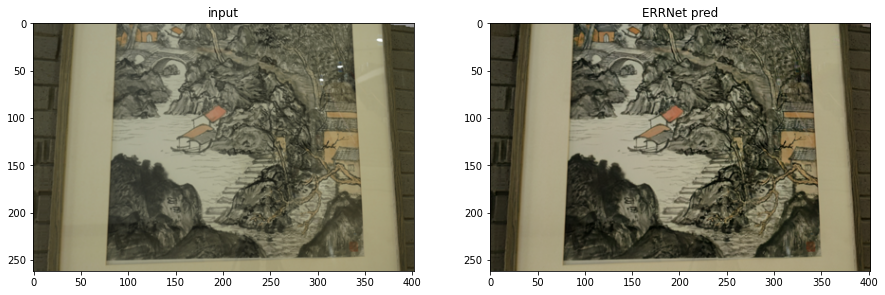

In [17]:
plt.subplots(figsize=(15, 8))
plt.subplot(121)
plt.title('input')
plt.imshow(img.permute(1,2,0).cpu().detach().numpy())
plt.subplot(122)
plt.title('ERRNet pred')
plt.imshow(img_out[0].permute(1,2,0).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RuntimeError: The size of tensor a (256) must match the size of tensor b (1008) at non-singleton dimension 2

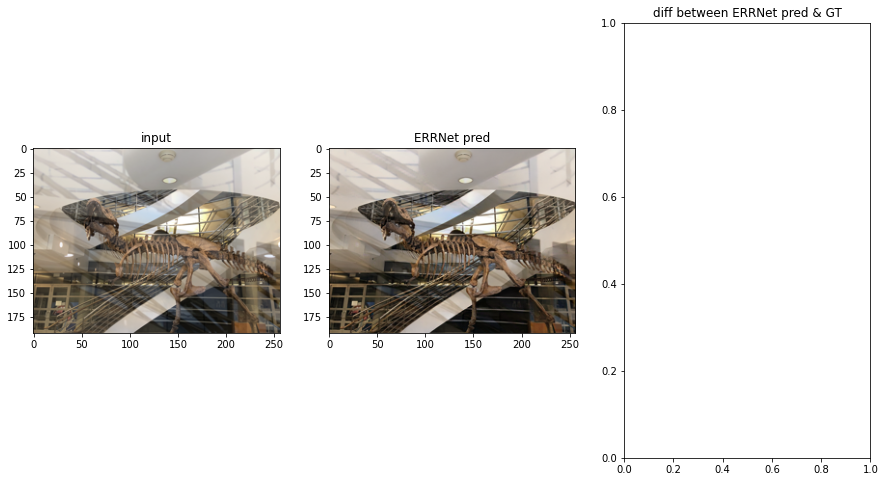

In [40]:
plt.subplots(figsize=(15, 8))
plt.subplot(131)
plt.title('input')
plt.imshow(img.permute(1,2,0).cpu().detach().numpy())
plt.subplot(132)
plt.title('ERRNet pred')
plt.imshow(img_out[0].permute(1,2,0).cpu().detach().numpy())
plt.subplot(133)
plt.title('diff between ERRNet pred & GT')
plt.imshow((img_out[0]-T.ToTensor()(img_ori)).permute(1,2,0).cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RuntimeError: The size of tensor a (990) must match the size of tensor b (989) at non-singleton dimension 2

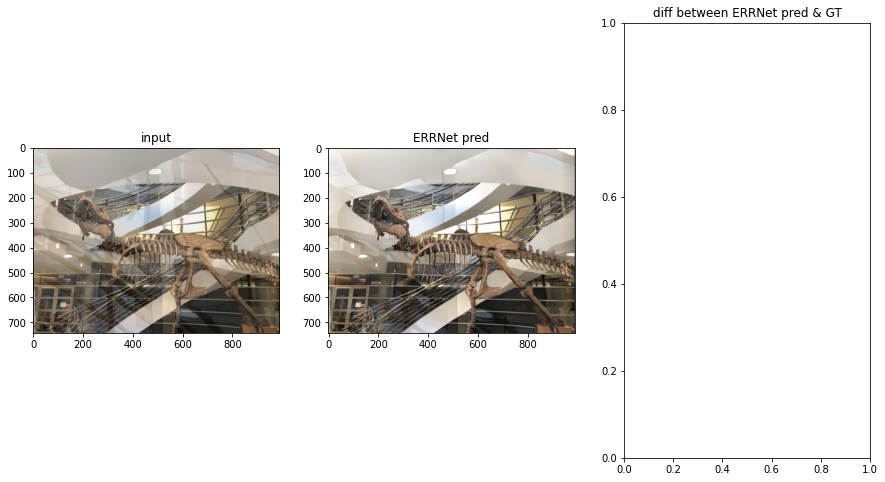

In [22]:
img = Image.open('/home/CORP.PKUSC.ORG/zcxpku/trex/images_4/2.jpg').convert('RGB')
img = T.ToTensor()(img)
with torch.no_grad():
    inp = img.unsqueeze(0)
    hypercolumn = vgg(inp)
    _, C, H, W = inp.shape
    hypercolumn = [F.interpolate(feature.detach(), size=(H, W), mode='bilinear', align_corners=False) for feature in hypercolumn]
    input_i = [inp]
    input_i.extend(hypercolumn)
    input_i = torch.cat(input_i, dim=1)
    B_encodeds = enc_B(input_i)
    img_out = enc_B(input_i)
plt.subplots(figsize=(15, 8))
plt.subplot(131)
plt.title('input')
plt.imshow(img.permute(1,2,0).cpu().detach().numpy())
plt.subplot(132)
plt.title('ERRNet pred')
plt.imshow(img_out[0].permute(1,2,0).cpu().detach().numpy())
plt.subplot(133)
plt.title('diff between ERRNet pred & GT')
plt.imshow((img_out[0]-img)).permute(1,2,0).cpu().detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TypeError: Invalid shape (3, 800, 1200) for image data

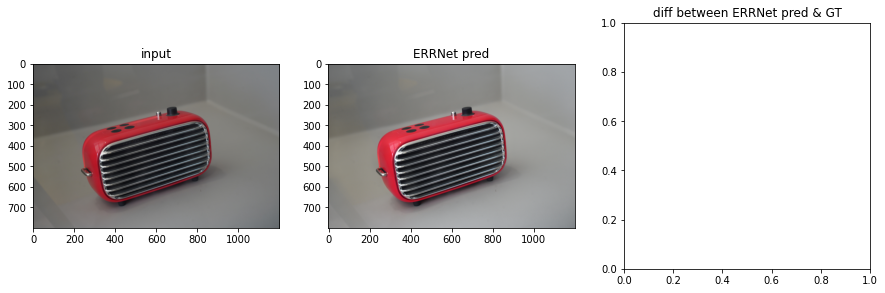

In [29]:
img = Image.open('/home/CORP.PKUSC.ORG/zcxpku/image00019.JPG').convert('RGB')
img = T.ToTensor()(img)
with torch.no_grad():
    inp = img.unsqueeze(0)
    hypercolumn = vgg(inp)
    _, C, H, W = inp.shape
    hypercolumn = [F.interpolate(feature.detach(), size=(H, W), mode='bilinear', align_corners=False) for feature in hypercolumn]
    input_i = [inp]
    input_i.extend(hypercolumn)
    input_i = torch.cat(input_i, dim=1)
    B_encodeds = enc_B(input_i)
    img_out = enc_B(input_i)
plt.subplots(figsize=(15, 8))
plt.subplot(131)
plt.title('input')
plt.imshow(img.permute(1,2,0).cpu().detach().numpy())
plt.subplot(132)
plt.title('ERRNet pred')
plt.imshow(img_out[0].permute(1,2,0).cpu().detach().numpy())
plt.subplot(133)
plt.title('diff between ERRNet pred & GT')
plt.imshow((img_out[0]-img)).permute(1,2,0).cpu().detach().numpy()

In [23]:
import piq
# piq.psnr(torch.clamp(img_out,0,1),T.ToTensor()(img_ori).unsqueeze(0))
piq.ssim(torch.clamp(img_out,0,1),T.ToTensor()(img_ori).unsqueeze(0))

tensor(0.9651)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


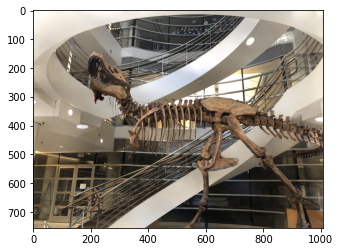

In [13]:
plt.imshow(img_out[0].permute(1,2,0).cpu().detach().numpy())